# Outliers


- Skew mean
- Inflate variance
- Distort model performance
- Affect regression strongly
- Reduce model generalization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
churn_data = fetch_openml(name="Telco-Customer-Churn", version=1, as_frame=True)
df = churn_data.frame

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

num_cols = df.select_dtypes(include=np.number).columns
num_cols


Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

## Visualization

### Boxplot
- Median
- IQR
- Whiskers
- Outliers (dots)

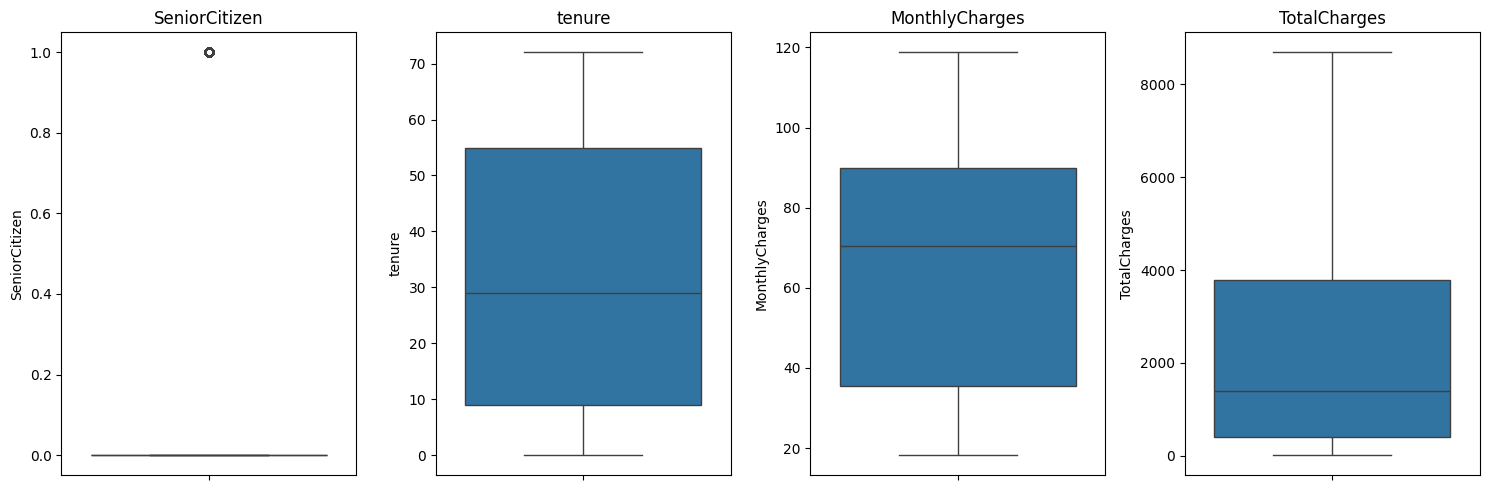

In [3]:
plt.figure(figsize=(15,5))

for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Distribution Plot

- frequencies
- skewness

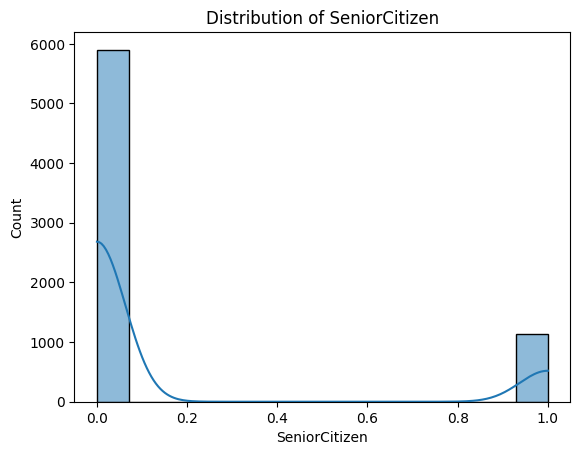

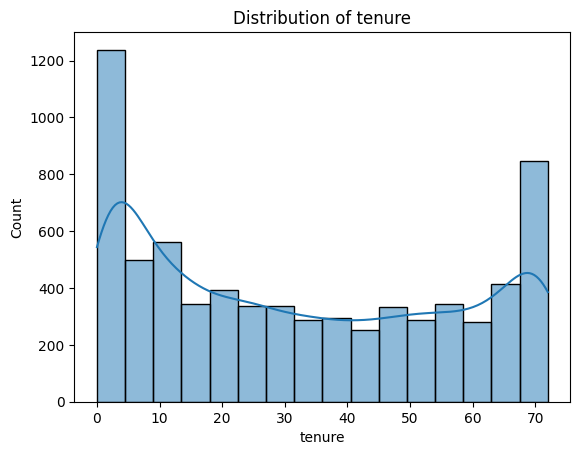

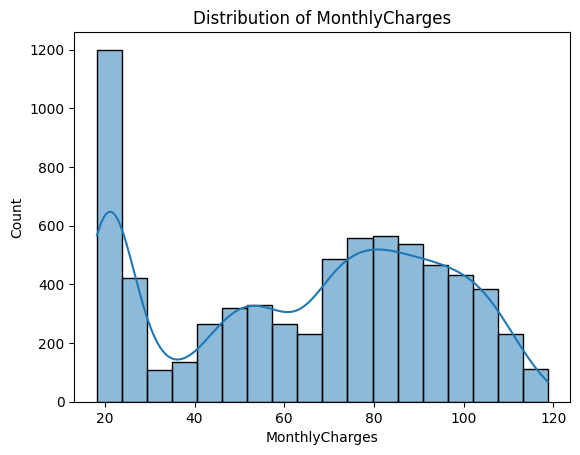

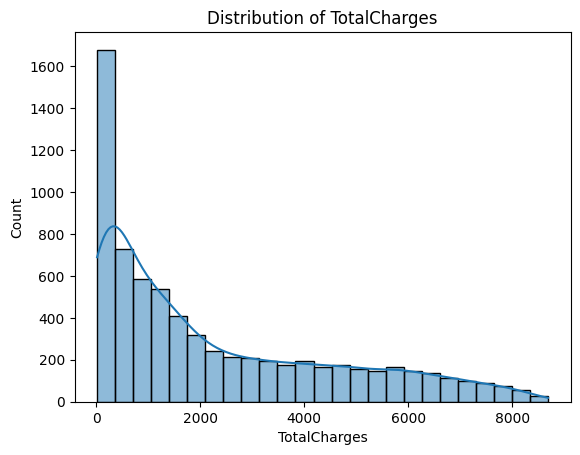

In [4]:
for col in num_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

### Scatterplot

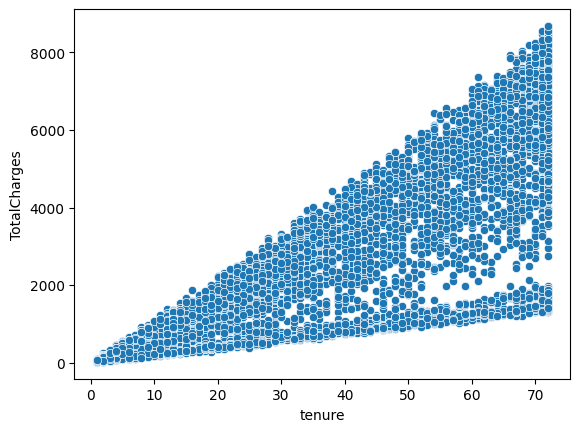

In [5]:
sns.scatterplot(x='tenure', y='TotalCharges', data=df)
plt.show()

## IQR Method

In [8]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.30)
    Q3 = data[column].quantile(0.70)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower) | (data[column] > upper)]

    return outliers, lower, upper

In [9]:
outliers_mc, lower, upper = detect_outliers_iqr(df, 'MonthlyCharges')

print("Number of outliers:", len(outliers_mc))

Number of outliers: 0


### Z-Score

In [10]:
from scipy import stats

z_scores = np.abs(stats.zscore(df['MonthlyCharges']))
outliers_z = df[z_scores > 3]

print("Outliers using Z-score:", len(outliers_z))


Outliers using Z-score: 0


In [11]:
lower = df['MonthlyCharges'].quantile(0.01)
upper = df['MonthlyCharges'].quantile(0.99)

outliers_percentile = df[(df['MonthlyCharges'] < lower) |
                         (df['MonthlyCharges'] > upper)]


### Isolation Forest

In [12]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.02, random_state=42)
df['outlier_flag'] = iso.fit_predict(df[num_cols])

df[df['outlier_flag'] == -1].shape

(141, 21)

In [13]:
df_clean = df[(df['MonthlyCharges'] >= lower) &
              (df['MonthlyCharges'] <= upper)]


### Winsorization

In [14]:
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    data[column] = np.where(data[column] > upper, upper,
                            np.where(data[column] < lower, lower,
                                     data[column]))
    return data


In [15]:
df_capped = cap_outliers(df.copy(), 'MonthlyCharges')


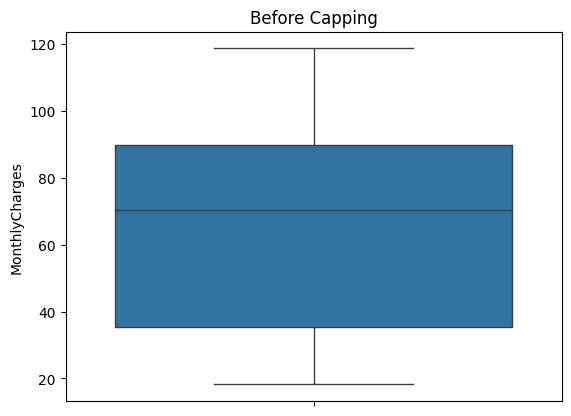

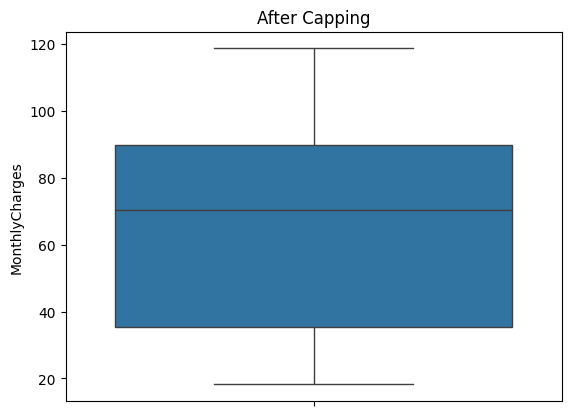

In [16]:
sns.boxplot(y=df['MonthlyCharges'])
plt.title("Before Capping")
plt.show()

sns.boxplot(y=df_capped['MonthlyCharges'])
plt.title("After Capping")
plt.show()